# **Train Test Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
!pip install tlbo

ERROR: Could not find a version that satisfies the requirement tlbo (from versions: none)
ERROR: No matching distribution found for tlbo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (concatenate,Conv2D,MaxPool2D,add,Input,Dense,Flatten,
                                     BatchNormalization,Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import (RMSprop,Adam)
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping as ES
from tensorflow_addons.optimizers import (RectifiedAdam,Lookahead)
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import plot_model as pm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_absolute_error as MSE
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
def R2 (true,predicted):
    import numpy as np
    R2 = np.mean((predicted-predicted.mean())*(true-true.mean()))/(np.std(predicted)*np.std(true))
    return R2

**import data**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/img/data.xlsx')
orig_df = df.copy()
df

,index,CGR,NPHI,PEF,RESD,RESX,RHOB,SGR,log(NMR_PERM)
0,0,0.581007,0.187088,0.626319,0.356231,0.292939,0.684603,0.426369,0.144913
1,1,0.490225,0.128213,0.666668,0.442034,0.332189,0.719365,0.352876,0.133279
2,2,0.411140,0.105342,0.695993,0.436939,0.359368,0.733794,0.288896,0.198111
3,3,0.342359,0.101894,0.718780,0.426162,0.370579,0.733531,0.231029,0.272135
4,4,0.312703,0.099486,0.731391,0.446326,0.374364,0.722566,0.204826,0.291435
...,...,...,...,...,...,...,...,...,...
6478,6478,0.249806,0.245387,0.648688,0.382449,0.569494,0.597250,0.231344,0.629230
6479,6479,0.234380,0.259585,0.633787,0.356433,0.544754,0.565176,0.220226,0.640021
6480,6480,0.237015,0.260957,0.616715,0.361464,0.517871,0.540058,0.225041,0.636215
6481,6481,0.223796,0.263455,0.608258,0.366017,0.500587,0.519614,0.213198,0.638169


In [ ]:
target = df.pop('log(NMR_PERM)').values
index = df.pop('index')
features = df

**float to bin function definition**

In [ ]:
def float_to_bin(arr, places = 32):
    import matplotlib.pyplot as plt
    bin_list = []
    for number in arr:
        whole, dec = str(number).split(".")
        whole = int(whole)
        dec = int (dec)
        res = bin(whole).lstrip("0b") + "."
        for x in range(places):
            whole, dec = str((decimal_converter(dec)) * 2).split(".")
            dec = int(dec)
            res += whole
        res = res.split('.')[1]
        res = [float(i) for i in res]
        bin_list.append(res)
        #fig = plt.imshow(bin_list,cmap='gray');
    fig=1
    return [bin_list,fig]
def decimal_converter(num):
    while num > 1:
        num /= 10
    return num

**convert decimal data to binary data**

In [ ]:
bin_list = []
fig_list = []
with tqdm(total=len(features.values), desc="Progress", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
  for i in features.values:
      bin_num,fig = float_to_bin(i,32)
      bin_list.append(bin_num)
      fig_list.append(fig)
      pbar.update(1)
feature = np.array(bin_list)
feature = np.array([i.reshape(i.shape[0],i.shape[1],1) for i in feature])
print('No. of Samples:',len(feature))
print('Sample Shape:',feature[0].shape)
orig_df['feature binary string'] = [i for i in feature]
del bin_list
orig_df

Progress: 100%|██████████ [ time left: 00:00 ]


No. of Samples: 6483
Sample Shape: (7, 32, 1)


,index,CGR,NPHI,PEF,RESD,RESX,RHOB,SGR,log(NMR_PERM),feature binary string
0,0,0.581007,0.187088,0.626319,0.356231,0.292939,0.684603,0.426369,0.144913,"[[[1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0..."
1,1,0.490225,0.128213,0.666668,0.442034,0.332189,0.719365,0.352876,0.133279,"[[[0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0..."
2,2,0.411140,0.105342,0.695993,0.436939,0.359368,0.733794,0.288896,0.198111,"[[[0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0..."
3,3,0.342359,0.101894,0.718780,0.426162,0.370579,0.733531,0.231029,0.272135,"[[[0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1..."
4,4,0.312703,0.099486,0.731391,0.446326,0.374364,0.722566,0.204826,0.291435,"[[[0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0..."
...,...,...,...,...,...,...,...,...,...,...
6478,6478,0.249806,0.245387,0.648688,0.382449,0.569494,0.597250,0.231344,0.629230,"[[[0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1..."
6479,6479,0.234380,0.259585,0.633787,0.356433,0.544754,0.565176,0.220226,0.640021,"[[[0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0..."
6480,6480,0.237015,0.260957,0.616715,0.361464,0.517871,0.540058,0.225041,0.636215,"[[[0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0..."
6481,6481,0.223796,0.263455,0.608258,0.366017,0.500587,0.519614,0.213198,0.638169,"[[[0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0..."


**Save Binary data**

In [ ]:
'''
from tqdm import tqdm
with tqdm(total=len(img_list), desc="Progress", bar_format="{l_bar}{bar} [ time left: {remaining} ]") as pbar:
    index = 0
    for i in img_list[index:]:
        fig = plt.imshow(i,cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig("D:/hassan sharifi/milad's project/img_resize/sample_"+str(index)+'.png',transparent=True)
        index+=1
        pbar.update(1)
'''

**Preprocessing**

In [ ]:
shape = feature[0].shape
xtr,xts,ytr,yts = tts(feature,target,train_size=0.7,random_state=1,shuffle=True)
print('xtr shape:',xtr.shape)
print('xts shape:',xts.shape)
print('ytr shape:',ytr.shape)
print('yts shape:',yts.shape)

xtr shape: (4538, 7, 32, 1)
xts shape: (1945, 7, 32, 1)
ytr shape: (4538,)
yts shape: (1945,)


**Model Creation**

In [ ]:
# 1
inputs = Input(shape= shape)
###################
X_1_1 = Conv2D(16,(1,1), activation="relu",padding='same')(inputs)
X_1_2 = Conv2D(64,(1,1), activation="relu",padding='same')(X_1_1)
X_1_3 = Conv2D(16,(3,3), activation="relu",padding='same')(X_1_2)
#X_1 = Conv2D(64,(3,3), activation="relu",padding='same')(inputs)
###################
X_2_1 = Conv2D(16,(1,1), activation="relu",padding='same')(X_1_3)
X_2_2 = Conv2D(64,(1,1), activation="relu",padding='same')(X_2_1)
X_2_3 = Conv2D(16,(3,3), activation="relu",padding='same')(X_2_2)
#X_2 = Conv2D(64,(3,3), activation="relu",padding='same')(X_1)
###################
X_3_1 = Conv2D(16,(1,1), activation="relu",padding='same')(X_2_3)
X_3_2 = Conv2D(64,(1,1), activation="relu",padding='same')(X_3_1)
X_3_3 = Conv2D(16,(3,3), activation="relu",padding='same')(X_3_2)
#X_3 = Conv2D(64,(3,3), activation="relu",padding='same')(X_2)
###################
'''
X_4_1 = Conv2D(16,(1,1), activation="relu",padding='same')(X_3_3)
X_4_2 = Conv2D(64,(1,1), activation="relu",padding='same')(X_4_1)
X_4_3 = Conv2D(16,(3,3), activation="relu",padding='same')(X_4_2)
#X_4 = Conv2D(64,(3,3), activation="relu",padding='same')(X_1)
'''
###################
C_1 = add([X_1_3, X_3_3])
#C_1 = add([X_3, X_4])
###################
X_5_1 = Conv2D(32,(1,1), activation="relu",padding='same')(C_1)
X_5_2 = Conv2D(128,(1,1), activation="relu",padding='same')(X_5_1)
X_5_3 = Conv2D(32,(3,3), activation="relu",padding='same')(X_5_2)
#X_5 = Conv2D(128,(3,3), activation="relu")(C_1)
mx_pool = MaxPool2D((2,2))(X_5_3)
###################
fltn = Flatten()(mx_pool)
D_1 = Dense(20,activation='relu')(fltn)

outputs = Dense(1)(D_1)
model = Model(inputs, outputs)

In [ ]:
# 2
inputs = Input(shape= shape)
###################
X_1_1 = Conv2D(16,(1,1), activation="relu",padding='valid')(inputs)
X_1_2 = Conv2D(64,(1,1), activation="relu",padding='valid')(X_1_1)
X_1_3 = Conv2D(16,(3,3), activation="relu",padding='valid')(X_1_2)
###################
mx_pool = MaxPool2D((2,2))(X_1_3)
fltn = Flatten()(mx_pool)
D_1 = Dense(20,activation='relu')(fltn)

outputs = Dense(1)(D_1)
model = Model(inputs, outputs)

In [ ]:
# 3
inputs = Input(shape= shape)
###################
X_1_1 = Conv2D(16,(1,1), activation="relu",padding='same')(inputs)
X_1_2 = Conv2D(64,(1,1), activation="relu",padding='same')(X_1_1)
X_1_3 = Conv2D(16,(3,3), activation="relu",padding='same')(X_1_2)
###################
conc = add([X_1_1,X_1_3])
###################
mx_pool = MaxPool2D((2,2))(conc)
fltn = Flatten()(mx_pool)
D_1 = Dense(20,activation='relu')(fltn)

outputs = Dense(1)(D_1)
model = Model(inputs, outputs)

In [ ]:
# 4
inputs = Input(shape= shape)
###################
X_1 = Conv2D(16,(1,1),padding='valid')(inputs)
ac_1 = Activation('relu')(X_1)
bt_1 = BatchNormalizationa()(ac_1)
X_2 = Conv2D(64,(1,1), padding='valid')(bt_1)
ac_2 = Activation('relu')(X_2)
bt_2 = BatchNormalizationa()(ac_2)
X_3 = Conv2D(16,(3,3),padding='valid')(bt_2)
ac_3 = Activation('relu')(X_3)
bt_3 = BatchNormalizationa()(ac_3)
###################
fltn = Flatten()(bt_3)
D_1 = Dense(20,activation='relu')(fltn)

outputs = Dense(1)(D_1)
model = Model(inputs, outputs)

In [ ]:
# 5
inputs = Input(shape= (7, 32, 1))
X_1 = Conv2D(16,(3,3),padding='same')(inputs)
btn_1 = BatchNormalization()(X_1)
act_1 = Activation('relu')(btn_1)
X_2 = Conv2D(32,(3,3), padding='same')(act_1)
btn_2 = BatchNormalization()(X_2)
act_2 = Activation('relu')(btn_2)
X_3 = Conv2D(64,(3,3), padding='same')(act_2)
btn_3 = BatchNormalization()(X_3)
act_3 = Activation('relu')(btn_3)
X_4 = Conv2D(64,(3,3), padding='same')(X_1)
btn_4 = BatchNormalization()(X_4)
act_4 = Activation('relu')(btn_4)
C_1 = concatenate([act_3, act_4])
X_5 = Conv2D(64,(3,3))(C_1)
btn_5 = BatchNormalization()(X_5)
act_5 = Activation('relu')(btn_5)
#M_3 = MaxPool2D((2,2))(act_5)
fltn = Flatten()(btn_5)
D_1 = Dense(20,activation='relu')(fltn)
outputs = Dense(1)(D_1)
model = Model(inputs, outputs)

In [ ]:
# 6
inputs = Input(shape= (7, 32, 1))
X_1 = Conv2D(16,(3,3),activation='relu',padding='same')(inputs)
X_2 = Conv2D(32,(3,3),activation='relu', padding='same')(X_1)
X_3 = Conv2D(64,(3,3),activation='relu', padding='same')(X_2)
X_4 = Conv2D(64,(3,3),activation='relu', padding='same')(X_1)
C_1 = concatenate([x_3, x_4])
X_5 = Conv2D(64,(3,3),activation='relu')(C_1)
#M_3 = MaxPool2D((2,2))(act_5)
fltn = Flatten()(X_5)
D_1 = Dense(20,activation='relu')(fltn)
outputs = Dense(1)(D_1)
model = Model(inputs, outputs)

In [ ]:
# 7
inputs = Input(shape= (7, 32, 1))
###################################
X_1_1 = Conv2D(4,(1,1),activation='relu',padding='same')(inputs)
X_1_2 = Conv2D(16,(1,1),activation='relu',padding='same')(X_1_1)
X_1_3 = Conv2D(4,(3,3),activation='relu',padding='same')(X_1_2)
###################################
X_2_1 = Conv2D(8,(1,1),activation='relu', padding='same')(X_1_3)
X_2_2 = Conv2D(32,(1,1),activation='relu', padding='same')(X_2_1)
X_2_3 = Conv2D(8,(3,3),activation='relu', padding='same')(X_2_2)
###################################
X_3_1 = Conv2D(16,(1,1),activation='relu', padding='same')(X_2_3)
X_3_2 = Conv2D(64,(1,1),activation='relu', padding='same')(X_3_1)
X_3_3 = Conv2D(16,(3,3),activation='relu', padding='same')(X_3_2)
###################################
X_4_1 = Conv2D(16,(1,1),activation='relu', padding='same')(X_1_3)
X_4_2 = Conv2D(64,(1,1),activation='relu', padding='same')(X_4_1)
X_4_3 = Conv2D(16,(3,3),activation='relu', padding='same')(X_4_2)
###################################
C_1 = concatenate([X_3_3, X_4_3])
###################################
X_5_1 = Conv2D(16,(1,1),activation='relu')(C_1)
X_5_2 = Conv2D(64,(1,1),activation='relu')(X_5_1)
X_5_3 = Conv2D(16,(3,3),activation='relu')(X_5_2)
###################################
#M_3 = MaxPool2D((2,2))(act_5)
fltn = Flatten()(X_5_3)
D_1 = Dense(20,activation='relu')(fltn)
outputs = Dense(1)(D_1)
model = Model(inputs, outputs)

In [ ]:
radam = RectifiedAdam(learning_rate=0.0001)
ranger = Lookahead(radam, sync_period=6, slow_step_size=0.5)
model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.0001))

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 7, 32, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 7, 32, 4)     8           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 7, 32, 16)    80          conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 7, 32, 4)     580         conv2d_18[0][0]                  
____________________________________________________________________________________________

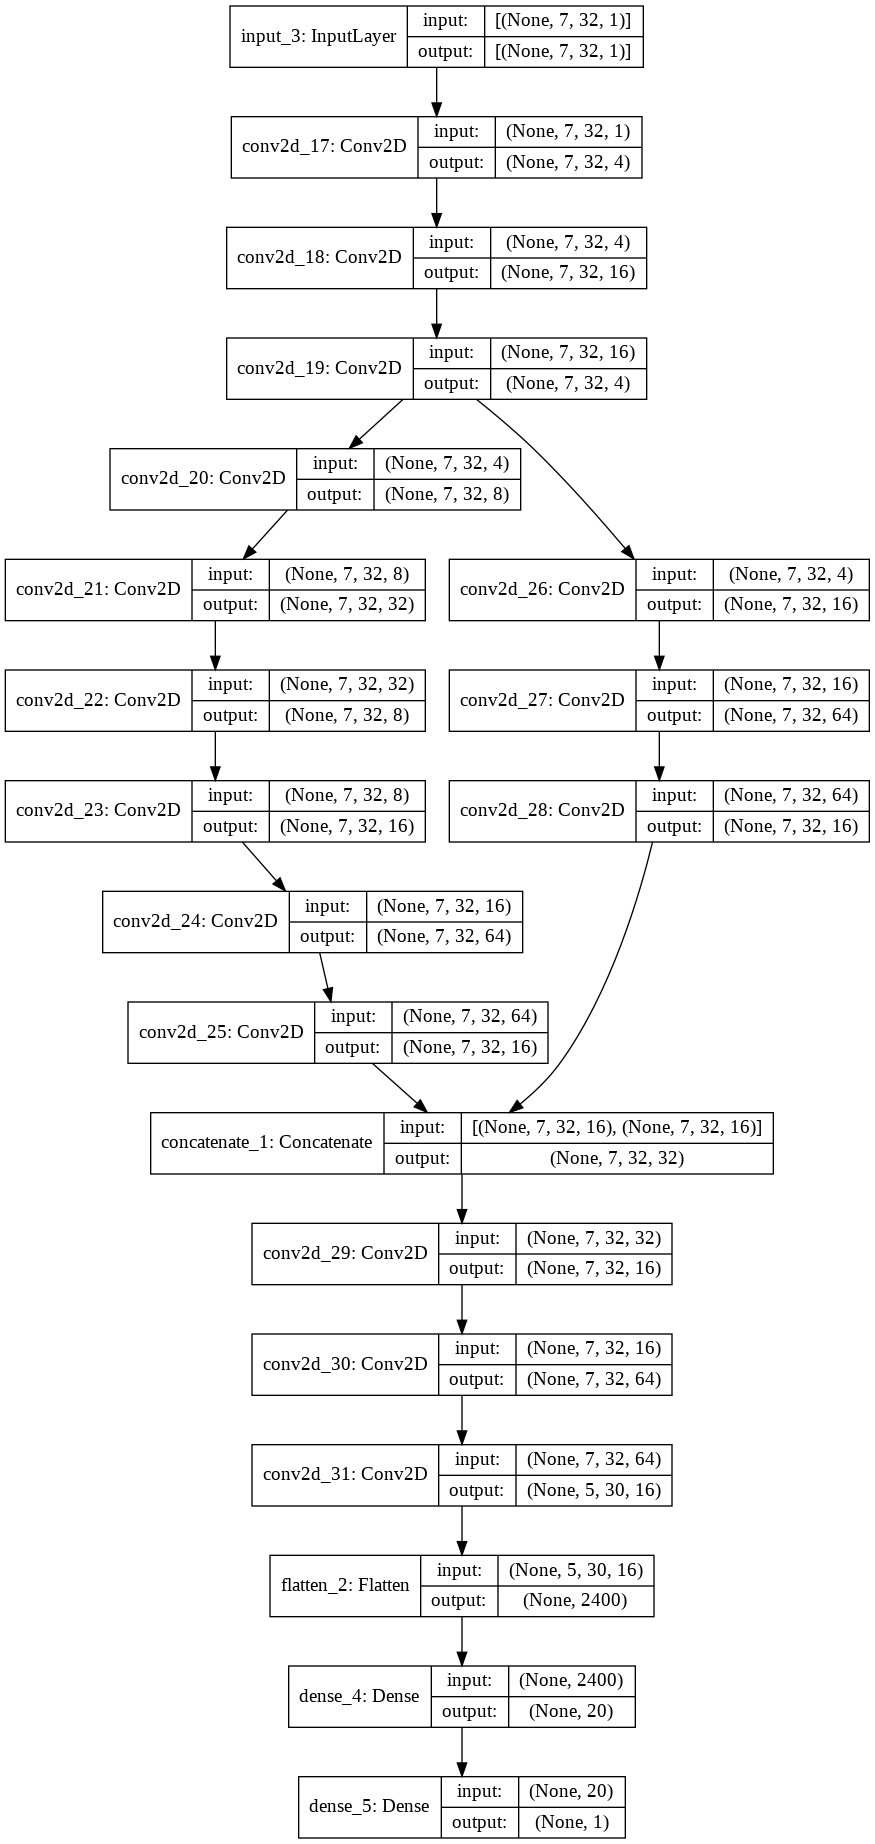

In [ ]:
pm(model,show_shapes=True)

**model training**

In [ ]:
hist = model.fit(xtr,ytr,
                 epochs=2000,validation_split=0.3,batch_size=64,verbose=1,
                 callbacks = [ES(monitor='val_loss', patience=20,
                                 restore_best_weights=True)])

Epoch 1/2000
50/50 [==============================] - 14s 271ms/step - loss: 0.0449 - val_loss: 0.1557
Epoch 2/2000
50/50 [==============================] - 13s 269ms/step - loss: 0.0265 - val_loss: 0.1143
Epoch 3/2000
50/50 [==============================] - 14s 289ms/step - loss: 0.0174 - val_loss: 0.1064
Epoch 4/2000
50/50 [==============================] - 13s 270ms/step - loss: 0.0126 - val_loss: 0.1044
Epoch 5/2000
50/50 [==============================] - 13s 270ms/step - loss: 0.0094 - val_loss: 0.0970
Epoch 6/2000
50/50 [==============================] - 13s 270ms/step - loss: 0.0071 - val_loss: 0.0747
Epoch 7/2000
50/50 [==============================] - 13s 269ms/step - loss: 0.0055 - val_loss: 0.0595
Epoch 8/2000
50/50 [==============================] - 13s 268ms/step - loss: 0.0043 - val_loss: 0.0518
Epoch 9/2000
50/50 [==============================] - 14s 273ms/step - loss: 0.0034 - val_loss: 0.0457
Epoch 10/2000
50/50 [==============================] - 14s 273ms/step - l

KeyboardInterrupt: ignored

**model history**

Text(0, 0.5, 'loss')

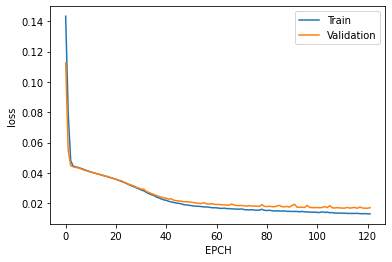

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss,label='Train')
plt.plot(val_loss,label='Validation')
plt.legend()
plt.xlabel('EPCH')
plt.ylabel('loss')

 **model eval on test set**

R2=  0.7569521172104807
MSE=  0.09902647616186357
RMSE=  0.31468472502151035


Text(0, 0.5, 'Value')

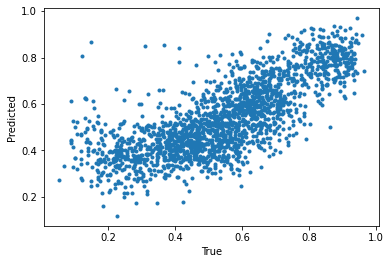

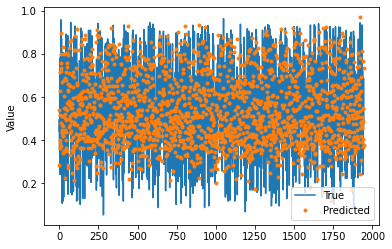

In [ ]:
yts_pred = model.predict(xts)
r2_ts = R2(yts_pred,yts.reshape(-1,1))
print('R2= ',r2_ts)
mse_ts = MSE(yts,yts_pred)
rmse_ts = mse_ts**0.5
print('MSE= ',mse_ts)
print('RMSE= ',rmse_ts)
plt.figure()
plt.plot(yts,yts_pred,'.')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.figure()
plt.plot(yts,label='True')
plt.plot(yts_pred,'.',label='Predicted')
plt.legend()
plt.ylabel('Value')

**model eval on train set**

R2=  0.8026041425087476
MSE=  0.09101642419567228
RMSE=  0.30168928419099056


Text(0, 0.5, 'Value')

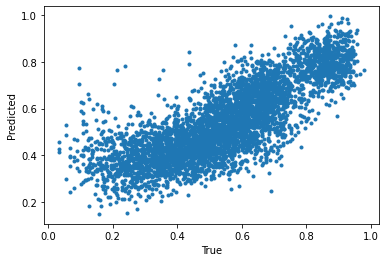

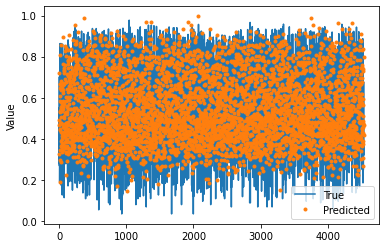

In [ ]:
ytr_pred = model.predict(xtr)
r2_tr = R2(ytr.reshape(-1,1),ytr_pred)
print('R2= ',r2_tr)
mse_tr = MSE(ytr,ytr_pred)
rmse_tr = mse_tr**0.5
print('MSE= ',mse_tr)
print('RMSE= ',rmse_tr)
plt.figure()
plt.plot(ytr,ytr_pred,'.')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.figure()
plt.plot(ytr,label='True')
plt.plot(ytr_pred,'.',label='Predicted')
plt.legend()
plt.ylabel('Value')

#**Blind Well Data**

**import data**

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/img_b/data_bw.xlsx')
orig_df = df.copy()
df

,index,CGR,NPHI,PEF,RESD,RESX,RHOB,SGR,log(NMR_PERM)
0,0,0.169355,0.275185,0.603290,0.358444,0.494000,0.503922,0.151025,0.624142
1,1,0.177758,0.279660,0.603561,0.351080,0.490961,0.496511,0.152631,0.624891
2,2,0.201791,0.305595,0.601401,0.336133,0.469396,0.483760,0.167486,0.610773
3,3,0.192143,0.322710,0.597857,0.332302,0.449326,0.479553,0.156186,0.636303
4,4,0.193589,0.327439,0.594776,0.336675,0.452110,0.485374,0.158116,0.657730
...,...,...,...,...,...,...,...,...,...
3986,3986,0.231449,0.021246,0.707459,0.691866,0.810585,0.767973,0.265253,0.439592
3987,3987,0.230531,0.031762,0.707242,0.651921,0.636860,0.767021,0.269853,0.473216
3988,3988,0.224254,0.067631,0.680304,0.619676,0.469571,0.752310,0.272525,0.246602
3989,3989,0.224297,0.149730,0.639783,0.653820,0.441691,0.730831,0.278252,0.497955


In [ ]:
target = df.pop('log(NMR_PERM)').values
index = df.pop('index')
features = df
features

,CGR,NPHI,PEF,RESD,RESX,RHOB,SGR
0,0.169355,0.275185,0.603290,0.358444,0.494000,0.503922,0.151025
1,0.177758,0.279660,0.603561,0.351080,0.490961,0.496511,0.152631
2,0.201791,0.305595,0.601401,0.336133,0.469396,0.483760,0.167486
3,0.192143,0.322710,0.597857,0.332302,0.449326,0.479553,0.156186
4,0.193589,0.327439,0.594776,0.336675,0.452110,0.485374,0.158116
...,...,...,...,...,...,...,...
3986,0.231449,0.021246,0.707459,0.691866,0.810585,0.767973,0.265253
3987,0.230531,0.031762,0.707242,0.651921,0.636860,0.767021,0.269853
3988,0.224254,0.067631,0.680304,0.619676,0.469571,0.752310,0.272525
3989,0.224297,0.149730,0.639783,0.653820,0.441691,0.730831,0.278252


**convert decimalto binary**


In [ ]:
bin_list = []
fig_list = []
for i in features.values:
    bin_num,fig = float_to_bin(i,32)
    bin_list.append(bin_num)
    fig_list.append(fig)
x_bw = np.array(bin_list)
x_bw = np.array([i.reshape(i.shape[0],i.shape[1],1) for i in x_bw])
y_bw = target
orig_df['feature binary string'] = [i  for i in x_bw]
del target
del bin_list
print('No. of Samples:',len(x_bw))
print('Sample Shape:',x_bw[0].shape)
print('features shape:',x_bw.shape)
print('target shape:',y_bw.shape)
orig_df

No. of Samples: 3991
Sample Shape: (7, 32, 1)
features shape: (3991, 7, 32, 1)
target shape: (3991,)


**model eval on blind well set**

R2=  0.7649854529092298
MSE=  0.12505955575787941
RMSE=  0.35363760512405834


Text(0, 0.5, 'Value')

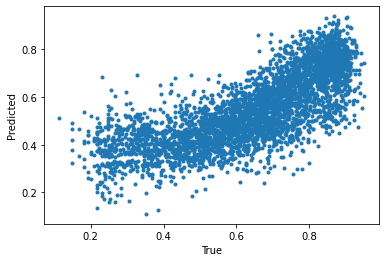

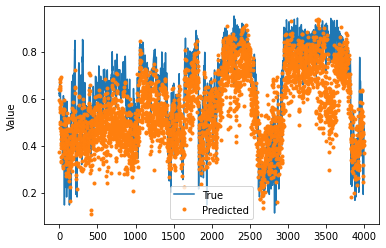

In [ ]:
ybw_pred = model.predict(x_bw)
r2_tr = R2(y_bw.reshape(-1,1),ybw_pred)
print('R2= ',r2_tr)
mse_tr = MSE(y_bw,ybw_pred)
rmse_tr = mse_tr**0.5
print('MSE= ',mse_tr)
print('RMSE= ',rmse_tr)
plt.figure()
plt.plot(y_bw,ybw_pred,'.')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.figure()
plt.plot(y_bw,label='True')
plt.plot(ybw_pred,'.',label='Predicted')
plt.legend()
plt.ylabel('Value')

In [ ]:
# python implementation of Teaching learning based optimization (TLBO)
# minimizing rastrigin and sphere function

import random
import math  # cos() for Rastrigin
import copy  # array-copying convenience
import sys  # max float


# -------fitness functions---------

# rastrigin functon
def fitness_rastrigin(position):
    fitness_value = 0.0
    for i in range(len(position)):
        xi = position[i]
        fitness_value += (xi * xi) - (10 * math.cos(2 * math.pi * xi)) + 10
    return fitness_value


# sphere function
def fitness_sphere(position):
    fitness_value = 0.0
    for i in range(len(position)):
        xi = position[i]
        fitness_value += (xi * xi);
    return fitness_value;


# -------------------------

# Student class
class Student:
    def __init__(self, fitness, dim, minx, maxx, seed):
        self.rnd = random.Random(seed)

        # a list of size dim
        # with 0.0 as value of all the elements
        self.position = [0.0 for i in range(dim)]

        # loop dim times and randomly select value of decision var
        # value should be in between minx and maxx
        for i in range(dim):
            self.position[i] = ((maxx[i] - minx[i]) *
                                self.rnd.random() + minx[i])

        # compute the fitness of student
        self.fitness = fitness(self.position)


# Teaching learning based optimization
def tlbo(fitness, max_iter, n, dim, minx, maxx,verbose=True):
    rnd = random.Random(0)


    # create n random students
    classroom = [Student(fitness, dim, minx, maxx, i) for i in range(n)]

    # compute the value of best_position and best_fitness in the classroom
    Xbest = [0.0 for i in range(dim)]
    Fbest = sys.float_info.max

    for i in range(n):  # check each Student
        if classroom[i].fitness < Fbest:
            Fbest = classroom[i].fitness
        Xbest = copy.copy(classroom[i].position)

    # main loop of tlbo
    Iter = 0
    while Iter < max_iter:

        # after every 10 iterations
        # print iteration number and best fitness value so far
        if Iter > 1 and verbose==True:
            print("Iter = " + str(Iter) + " best fitness = %.3f" % Fbest)

        # for each student of classroom
        for i in range(n):

        ### Teaching phase of ith student

            # compute the mean of all the students in the class
            Xmean = [0.0 for i in range(dim)]
            for k in range(n):
                for j in range(dim):
                    Xmean[j] += classroom[k].position[j]

            for j in range(dim):
                Xmean[j] /= n;

            # initialize new solution
            Xnew = [0.0 for i in range(dim)]

            # teaching factor (TF)
            # either 1 or 2 ( randomly chosen)
            TF = random.randint(1, 3)

            # best student of the class is teacher
            Xteacher = Xbest

            # compute new solution
            for j in range(dim):
                Xnew[j] = classroom[i].position[j] + rnd.random() * (Xteacher[j] - TF * Xmean[j])

            # if Xnew < minx OR Xnew > maxx
            # then clip it
            for j in range(dim):
                Xnew[j] = max(Xnew[j], minx[j])
                Xnew[j] = min(Xnew[j], maxx[j])

            # compute fitness of new solution
            fnew = fitness(Xnew)

            # if new solution is better than old
            # replace old with new solution
            if (fnew < classroom[i].fitness):
                classroom[i].position = Xnew
                classroom[i].fitness = fnew

            # update best student
            if (fnew < Fbest):
                Fbest = fnew
                Xbest = Xnew

            ### learning phase of ith student

            # randomly choose a solution from classroom
            # chosen solution should not be ith student
            p = random.randint(0, n - 1)
            while (p == i):
                p = random.randint(0, n - 1)

            # partner solution
            Xpartner = classroom[p]

            Xnew = [0.0 for i in range(dim)]
            if (classroom[i].fitness < Xpartner.fitness):
                for j in range(dim):
                    Xnew[j] = classroom[i].position[j] + rnd.random() * (classroom[i].position[j] - Xpartner.position[j])
            else:
                for j in range(dim):
                    Xnew[j] = classroom[i].position[j] - rnd.random() * (classroom[i].position[j] - Xpartner.position[j])

            # if Xnew < minx OR Xnew > maxx
            # then clip it
            for j in range(dim):
                Xnew[j] = max(Xnew[j], minx[j])
                Xnew[j] = min(Xnew[j], maxx[j])

            # compute fitness of new solution
            fnew = fitness(Xnew)

            # if new solution is better than old
            # replace old with new solution
            if (fnew < classroom[i].fitness):
                classroom[i].position = Xnew
                classroom[i].fitness = fnew

            # update best student
            if (fnew < Fbest):
                Fbest = fnew
                Xbest = Xnew

        Iter += 1
    # end-while

    # return best student from classroom
    return Xbest
    # end pso


# ----------------------------
'''
# Driver code for rastrigin function

print("\nBegin teaching learning based optimization on rastrigin function\n")
dim = 3
fitness = fitness_rastrigin

print("Goal is to minimize Rastrigin's function in " + str(dim) + " variables")
print("Function has known min = 0.0 at (", end="")
for i in range(dim - 1):
    print("0, ", end="")
print("0)")

num_particles = 50
max_iter = 100

print("Setting num_particles = " + str(num_particles))
print("Setting max_iter = " + str(max_iter))
print("\nStarting TLBO algorithm\n")

best_position = tlbo(fitness, max_iter, num_particles, dim, -10.0, 10.0)

print("\nTLBO completed\n")
print("\nBest Student found:")
print(["%.6f" % best_position[k] for k in range(dim)])
fitness_value = fitness(best_position)
print("fitness of best Student = %.6f" % fitness_value)

print("\nEnd TLBO for rastrigin function\n")

print()
print()

# Driver code for Sphere function
print("\nBegin teaching learning based optimization on sphere function\n")
dim = 3
fitness = fitness_sphere

print("Goal is to minimize sphere function in " + str(dim) + " variables")
print("Function has known min = 0.0 at (", end="")
for i in range(dim - 1):
    print("0, ", end="")
print("0)")

num_particles = 50
max_iter = 100

print("Setting num_particles = " + str(num_particles))
print("Setting max_iter = " + str(max_iter))
print("\nStarting TLBO algorithm\n")

best_position = tlbo(fitness, max_iter, num_particles, dim, -10.0, 10.0)

print("\nTLBO completed\n")
print("\nBest Student found:")
print(["%.6f" % best_position[k] for k in range(dim)])
fitness_value = fitness(best_position)
print("fitness of best Student = %.6f" % fitness_value)

print("\nEnd TLBO for sphere function\n")
'''

'\n# Driver code for rastrigin function\n\nprint("\nBegin teaching learning based optimization on rastrigin function\n")\ndim = 3\nfitness = fitness_rastrigin\n\nprint("Goal is to minimize Rastrigin\'s function in " + str(dim) + " variables")\nprint("Function has known min = 0.0 at (", end="")\nfor i in range(dim - 1):\n    print("0, ", end="")\nprint("0)")\n\nnum_particles = 50\nmax_iter = 100\n\nprint("Setting num_particles = " + str(num_particles))\nprint("Setting max_iter = " + str(max_iter))\nprint("\nStarting TLBO algorithm\n")\n\nbest_position = tlbo(fitness, max_iter, num_particles, dim, -10.0, 10.0)\n\nprint("\nTLBO completed\n")\nprint("\nBest Student found:")\nprint(["%.6f" % best_position[k] for k in range(dim)])\nfitness_value = fitness(best_position)\nprint("fitness of best Student = %.6f" % fitness_value)\n\nprint("\nEnd TLBO for rastrigin function\n")\n\nprint()\nprint()\n\n# Driver code for Sphere function\nprint("\nBegin teaching learning based optimization on sphere 

# **Hyperparameter optimization**

In [ ]:
#%% Creat Cost Function to be optimized
def model_tun (params):
    global shape
    global x_bw
    global y_bw
    no_of_nor = int(round(params[0]))
    act = int(round(params[1]))
    if act==0:
        act='sigmoid'
    elif act==1:
        act='relu'
    no_dense = int(round(params[2]))
    lr = params[3]
    bt_size = int(round(params[4]))
    pait = int(round(params[5]))
    ############## model creating ##############
    inputs = Input(shape= (7, 32, 1))
    ###################################
    X_1_1 = Conv2D(int(round(no_of_nor/4)),(1,1),activation=act,padding='same')(inputs)
    X_1_2 = Conv2D(no_of_nor,(1,1),activation=act,padding='same')(X_1_1)
    X_1_3 = Conv2D(int(round(no_of_nor/4)),(3,3),activation=act,padding='same')(X_1_2)
    ###################################
    X_2_1 = Conv2D(int(round(no_of_nor/4)),(1,1),activation=act, padding='same')(X_1_3)
    X_2_2 = Conv2D(no_of_nor,(1,1),activation=act, padding='same')(X_2_1)
    X_2_3 = Conv2D(int(round(no_of_nor/4)),(3,3),activation=act, padding='same')(X_2_2)
    ###################################
    X_3_1 = Conv2D(int(round(no_of_nor/4)),(1,1),activation=act, padding='same')(X_2_3)
    X_3_2 = Conv2D(no_of_nor,(1,1),activation=act, padding='same')(X_3_1)
    X_3_3 = Conv2D(int(round(no_of_nor/4)),(3,3),activation=act, padding='same')(X_3_2)
    ###################################
    X_4_1 = Conv2D(int(round(no_of_nor/4)),(1,1),activation=act, padding='same')(X_1_3)
    X_4_2 = Conv2D(no_of_nor,(1,1),activation=act, padding='same')(X_4_1)
    X_4_3 = Conv2D(int(round(no_of_nor/4)),(3,3),activation=act, padding='same')(X_4_2)
    ###################################
    C_1 = concatenate([X_3_3, X_4_3])
    ###################################
    X_5_1 = Conv2D(int(round(no_of_nor/4)),(1,1),activation=act)(C_1)
    X_5_2 = Conv2D(no_of_nor,(1,1),activation=act)(X_5_1)
    X_5_3 = Conv2D(int(round(no_of_nor/4)),(3,3),activation=act)(X_5_2)
    ###################################
    #M_3 = MaxPool2D((2,2))(act_5)
    fltn = Flatten()(X_5_3)
    D_1 = Dense(no_dense,activation=act)(fltn)
    outputs = Dense(1)(D_1)
    model = Model(inputs, outputs)
    ###################### Model compile ########################
    model.compile(loss='mean_squared_error',optimizer=Adam(lr),metrics=['mse','mae'])
    ####################### Model fit #########################
    hist = model.fit(x_bw,y_bw,
             epochs=2000,validation_split=0.3,batch_size=bt_size,verbose=0,
             callbacks = [ES(monitor='val_loss', patience=pait,
                             restore_best_weights=True)])
    ##########################################################
    pred = model.predict(x_bw)
    mse = MSE(y_bw.reshape(-1,1),pred.reshape(-1,1))
    return mse
#%% setting optimizaer parameters
low_bond = [16,0,10,1e-6,16,5]
high_bond = [128,1,100,0.01,128,20]
max_iter = 100
num_particles = 60
dim = 6
#%% Optimizing
no_of_nor,act,no_dense,lr,bt_size,pait = tlbo(model_tun, max_iter, num_particles, dim, low_bond, high_bond,
                     verbose=True)